In [1]:
#from models.nalu import NALU
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [207]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

from models.nac import NeuralAccumulatorCell
from torch.nn.parameter import Parameter



import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

from torch.nn.parameter import Parameter


class NeuralAccumulatorCell(nn.Module):
    """A Neural Accumulator (NAC) cell [1].

    Attributes:
        in_dim: size of the input sample.
        out_dim: size of the output sample.

    Sources:
        [1]: https://arxiv.org/abs/1808.00508
    """
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.W = 0

        self.W_hat = Parameter(torch.Tensor(out_dim, in_dim))
        self.M_hat = Parameter(torch.Tensor(out_dim, in_dim))

        self.register_parameter('W_hat', self.W_hat)
        self.register_parameter('M_hat', self.M_hat)
        self.register_parameter('bias', None)

        self._reset_params()

    def _reset_params(self):
        init.kaiming_uniform_(self.W_hat)
        init.kaiming_uniform_(self.M_hat)

    def forward(self, input):
        W = torch.tanh(self.W_hat) * torch.sigmoid(self.M_hat)
        self.W = W
        return F.linear(input, W, self.bias)

    def extra_repr(self):
        return 'in_dim={}, out_dim={}'.format(
            self.in_dim, self.out_dim
        )


class NAC(nn.Module):
    """A stack of NAC layers.

    Attributes:
        num_layers: the number of NAC layers.
        in_dim: the size of the input sample.
        hidden_dim: the size of the hidden layers.
        out_dim: the size of the output.
    """
    def __init__(self, num_layers, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.num_layers = num_layers
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim

        layers = []
        for i in range(num_layers):
            layers.append(
                NeuralAccumulatorCell(
                    hidden_dim if i > 0 else in_dim,
                    hidden_dim if i < num_layers - 1 else out_dim,
                )
            )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out

    
class NeuralArithmeticLogicUnitCell(nn.Module):
    """A Neural Arithmetic Logic Unit (NALU) cell [1].

    Attributes:
        in_dim: size of the input sample.
        out_dim: size of the output sample.

    Sources:
        [1]: https://arxiv.org/abs/1808.00508
    """
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.eps = 1e-10

        self.G = Parameter(torch.Tensor(out_dim, in_dim))
        self.nac = NeuralAccumulatorCell(in_dim, out_dim)
        self.register_parameter('bias', None)

        init.kaiming_uniform_(self.G, a=math.sqrt(5))

    def forward(self, input):
        a = self.nac(input)
        g = torch.sigmoid(F.linear(input, self.G, self.bias))
        
        add_sub = g * a
        log_input = torch.log(torch.abs(input) + self.eps)
        m = torch.exp(self.nac(log_input))
        mul_div = (1 - g) * m
        y = add_sub + mul_div
        return y, g, self.nac.W

    def extra_repr(self):
        return 'in_dim={}, out_dim={}'.format(
            self.in_dim, self.out_dim
        )


class NALU(nn.Module):
    """A stack of NAC layers.

    Attributes:
        num_layers: the number of NAC layers.
        in_dim: the size of the input sample.
        hidden_dim: the size of the hidden layers.
        out_dim: the size of the output.
    """
    
    def __init__(self, num_layers, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.num_layers = num_layers
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.g = []
        self.W = []

        layers = []
        for i in range(num_layers):
            layers.append(
                NeuralArithmeticLogicUnitCell(
                    hidden_dim if i > 0 else in_dim,
                    hidden_dim if i < num_layers - 1 else out_dim,
                )
            )
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        out, g , W = self.model(x)
        
        self.W.append(W.data)
        self.g.append(g)
        return out

In [197]:
def test(model, data, target):
    with torch.no_grad():
        out = model(data)
        return torch.abs(target - out)

In [198]:
def train(model, optimizer, num_iters, support):
        
    for i in range(num_iters):
        
        data, target, X_test, y_test = generate_data(num_train, num_test, dim, num_sum, fn, support)
        #data = data.reshape(data.shape[0]*data.shape[1],1)
        #print(data)
        out = model(data)
        loss = F.mse_loss(out, target)
        mea = torch.mean(torch.abs(target - out))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            pass
            #print("\t{}/{}: loss: {:.7f} - mea: {:.7f}".format(
            #    i+1, num_iters, loss.item(), mea.item())
            #)
            

In [108]:
import random

In [109]:
def generate_data(num_train, num_test, dim, num_sum, fn, support):
    # dim = number of uniform points
    # support = range of distribution
    # num_test = number of points in test set
    # num_train = number of points in train set
    data = torch.FloatTensor(dim).uniform_(*support).unsqueeze_(1)
    
    X, y = [], []
    for i in range(num_train + num_test):
        
        # we find some random index in the data
        idx_a = random.sample(range(dim), num_sum)
        idx_b = random.sample([x for x in range(dim) if x not in idx_a], num_sum)
        
        # we calculate the som of these random index from the data
        a, b = data[idx_a].sum(), data[idx_b].sum()
        X.append([a, b])
        y.append(fn(a, b))
        
    X = torch.FloatTensor(X)
    y = torch.FloatTensor(y).unsqueeze_(1)
    
    indices = list(range(num_train + num_test))
    np.random.shuffle(indices)
    
    # lastly we divide into training and test.
    X_train, y_train = X[indices[num_test:]], y[indices[num_test:]]
    X_test, y_test = X[indices[:num_test]], y[indices[:num_test]]
    
    return X_train, y_train, X_test, y_test


In [110]:
out_dim = 1
hidden_dim = 1
in_dim = 2
num_layers = 1
net = NALU(num_layers, in_dim, hidden_dim, out_dim)
print(net)

NALU(
  (model): Sequential(
    (0): NeuralArithmeticLogicUnitCell(
      in_dim=2, out_dim=1
      (nac): NeuralAccumulatorCell(in_dim=2, out_dim=1)
    )
  )
)


# addition positive range

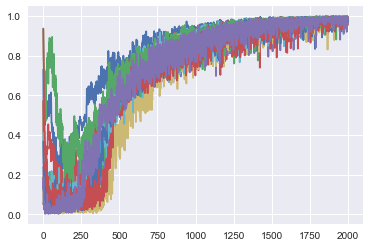

In [111]:
num_train = 1
num_test = 1
dim = 1000
num_sum = 5
fn = lambda x, y: x + y
support = [0, 1]

X_train, y_train, X_test, y_test = generate_data(num_train, num_test, dim, num_sum, fn, support)

experiments = 10
iterations = 2000

for i in range(experiments):

    out_dim = 1
    hidden_dim = 1
    in_dim = 2
    num_layers = 1
    net = NALU(num_layers, in_dim, hidden_dim, out_dim)

    optim = torch.optim.RMSprop(net.parameters(),lr=0.01)
    train(net, optim, iterations)

    g = torch.tensor(net.g).numpy()

    plt.plot(net.g)
    
plt.show()

# addition real range

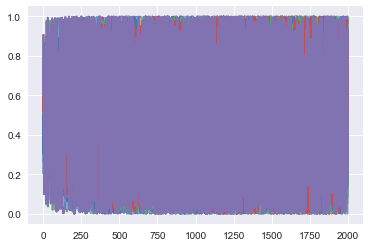

In [112]:
num_train = 1
num_test = 1
dim = 1000
num_sum = 5
fn = lambda x, y: x + y
support = [-1, 1]

experiments = 10
iterations = 2000

for i in range(experiments):

    out_dim = 1
    hidden_dim = 1
    in_dim = 2
    num_layers = 1
    net = NALU(num_layers, in_dim, hidden_dim, out_dim)

    optim = torch.optim.RMSprop(net.parameters(),lr=0.01)
    train(net, optim, iterations)

    g = torch.tensor(net.g).numpy()

    plt.plot(net.g)
    
plt.show()

# addition only negative

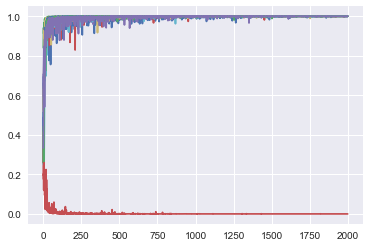

In [113]:
num_train = 1
num_test = 1
dim = 1000
num_sum = 5
fn = lambda x, y: x + y
support = [-1, 0]

experiments = 10
iterations = 2000

for i in range(experiments):

    out_dim = 1
    hidden_dim = 1
    in_dim = 2
    num_layers = 1
    net = NALU(num_layers, in_dim, hidden_dim, out_dim)

    optim = torch.optim.RMSprop(net.parameters(),lr=0.01)
    train(net, optim, iterations)

    g = torch.tensor(net.g).numpy()

    plt.plot(net.g)
    
plt.show()

# addition screwed range

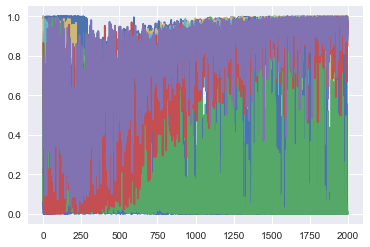

In [114]:
num_train = 1
num_test = 1
dim = 1000
num_sum = 5
fn = lambda x, y: x + y
support = [-1, 3]

experiments = 10
iterations = 2000

for i in range(experiments):

    out_dim = 1
    hidden_dim = 1
    in_dim = 2
    num_layers = 1
    net = NALU(num_layers, in_dim, hidden_dim, out_dim)

    optim = torch.optim.RMSprop(net.parameters(),lr=0.01)
    train(net, optim, iterations)

    g = torch.tensor(net.g).numpy()

    plt.plot(net.g)
    
plt.show()

# Multiplation

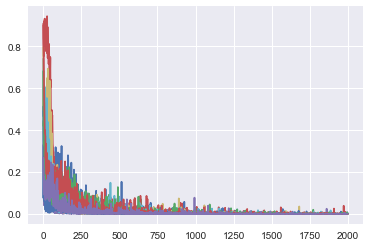

In [115]:
# Multiplication

num_train = 1
num_test = 1
dim = 1000
num_sum = 5
fn = lambda x, y: x * y
support = [0, 1]

X_train, y_train, X_test, y_test = generate_data(num_train, num_test, dim, num_sum, fn, support)

experiments = 10
iterations = 2000

for i in range(experiments):

    out_dim = 1
    hidden_dim = 1
    in_dim = 2
    num_layers = 1
    net = NALU(num_layers, in_dim, hidden_dim, out_dim)

    optim = torch.optim.RMSprop(net.parameters(),lr=0.01)
    train(net, optim, iterations)

    g = torch.tensor(net.g).numpy()

    plt.plot(net.g)
    
plt.show()

# Multiplication also negative numbers

[1.5270886e-01 1.2844108e-01 1.4931443e-01 ... 3.0091801e-03 1.9691391e-04
 5.0698995e-06]
[2.5403127e-01 2.2777966e-01 9.4165459e-02 ... 7.0144684e-05 1.2545122e-04
 5.6903730e-03]
[4.8991397e-01 1.9213901e-01 5.5408674e-01 ... 2.9031595e-05 5.8900104e-03
 7.8213016e-06]
[4.1646269e-01 4.1757548e-01 2.3244454e-01 ... 1.0803990e-03 6.3228962e-04
 1.1029499e-04]
[2.3415619e-01 1.4900248e-01 1.1780069e-01 ... 5.9564656e-04 2.1378260e-05
 2.6409321e-05]
[8.3227599e-01 8.0869216e-01 8.5682744e-01 ... 1.0431618e-03 3.7485497e-06
 2.2888914e-04]
[3.2725650e-01 2.1496452e-01 5.5413503e-02 ... 5.5723417e-06 1.4386946e-04
 1.5821686e-04]
[7.1257669e-01 6.6747761e-01 5.7297254e-01 ... 1.1443991e-06 5.7486843e-05
 1.1253599e-04]
[7.7555180e-01 7.9050153e-01 7.4925172e-01 ... 2.9673904e-05 4.5996116e-04
 1.1406799e-04]
[1.7180164e-01 9.2187718e-02 1.6643821e-01 ... 2.3929830e-05 8.6495717e-04
 6.2915889e-05]


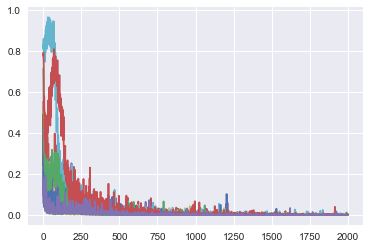

In [134]:
num_train = 1
num_test = 1
dim = 1000
num_sum = 5
fn = lambda x, y: x * y
support = [0, 1]

X_train, y_train, X_test, y_test = generate_data(num_train, num_test, dim, num_sum, fn, support)

experiments = 10
iterations = 2000

for i in range(experiments):

    out_dim = 1
    hidden_dim = 1
    in_dim = 2
    num_layers = 1
    net = NALU(num_layers, in_dim, hidden_dim, out_dim)

    optim = torch.optim.RMSprop(net.parameters(),lr=0.01)
    train(net, optim, iterations)

    g = torch.tensor(net.g).numpy()
    print(g)
    plt.plot(net.g)
    
plt.show()

# Weights (Addition)

tensor([[-14.5192, -20.8382]])


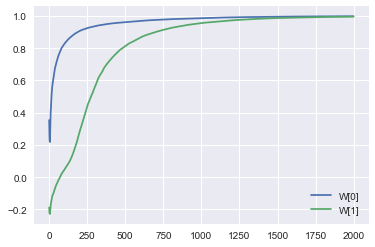

In [211]:
num_train = 1
num_test = 1
dim = 1000
num_sum = 5
fn = lambda x, y: x + y
support = [-5, -1]


print(X_train)
experiments = 1
iterations = 2000

for i in range(experiments):

    out_dim = 1
    hidden_dim = 1
    in_dim = 2
    num_layers = 1
    net = NALU(num_layers, in_dim, hidden_dim, out_dim)
    optim = torch.optim.RMSprop(net.parameters(),lr=0.01)
    train(net, optim, iterations,support)
    
    #g = torch.tensor(net.g).numpy()
    #print(len(net.W))
    W = net.W
    #print(W)
    #print(W[0].data.numpy()[0][0])
    n1 = []
    n2 = []
    for j in range(iterations):
        n1.append(W[j].data.numpy()[0][0])
        n2.append(W[j].data.numpy()[0][1])
    plt.plot(n1,label='W[0]')
    plt.plot(n2,label='W[1]')
    plt.legend()
    #plt.matshow(W)
plt.show()

# Weights (Subtraction)

tensor([[-17.9571,  10.1715]])


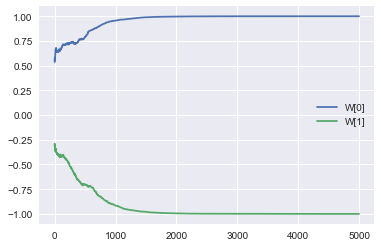

tensor([[ 1.0000, -1.0000]])


In [204]:
num_train = 1
num_test = 1
dim = 1000
num_sum = 5
fn = lambda x, y: x - y
support = [-5, 5]

X_train, y_train, X_test, y_test = generate_data(num_train, num_test, dim, num_sum, fn, support)
print(X_train)
experiments = 1
iterations = 5000

for i in range(experiments):

    out_dim = 1
    hidden_dim = 1
    in_dim = 2
    num_layers = 1
    net = NALU(num_layers, in_dim, hidden_dim, out_dim)
    optim = torch.optim.RMSprop(net.parameters(),lr=0.01)
    train(net, optim, iterations, support)
    
    g = torch.tensor(net.g).numpy()
    W = net.W
    n1 = []
    n2 = []
    for j in range(iterations):
        n1.append(W[j].data.numpy()[0][0])
        n2.append(W[j].data.numpy()[0][1])
    plt.plot(n1,label='W[0]')
    plt.plot(n2,label='W[1]')
    plt.legend()
    #plt.matshow(W)
plt.show()

print(W[-1].data)

# Weights (Multiplication)

tensor([[-14.5192, -20.8382]])


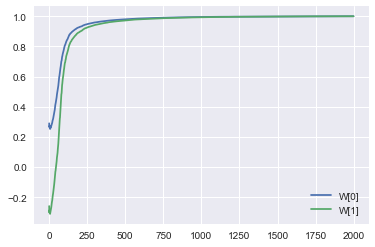

In [210]:
num_train = 1
num_test = 1
dim = 1000
num_sum = 5
fn = lambda x, y: x * y
support = [-5, -1]

X_train, y_train, X_test, y_test = generate_data(num_train, num_test, dim, num_sum, fn, support)
print(X_train)
experiments = 1
iterations = 2000

for i in range(experiments):

    out_dim = 1
    hidden_dim = 1
    in_dim = 2
    num_layers = 1
    net = NALU(num_layers, in_dim, hidden_dim, out_dim)
    optim = torch.optim.RMSprop(net.parameters(),lr=0.01)
    train(net, optim, iterations, support)
    
    g = torch.tensor(net.g).numpy()
    W = net.W
    n1 = []
    n2 = []
    for j in range(iterations):
        n1.append(W[j].data.numpy()[0][0])
        n2.append(W[j].data.numpy()[0][1])
    plt.plot(n1,label='W[0]')
    plt.plot(n2,label='W[1]')
    plt.legend()
    #plt.matshow(W)
plt.show()

# Weights (Division)

tensor([[2.3138, 1.9619]])


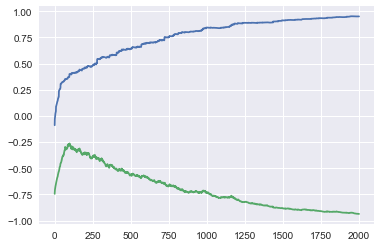

In [158]:
num_train = 1
num_test = 1
dim = 1000
num_sum = 5
fn = lambda x, y: x / y
support = [0, 1]

X_train, y_train, X_test, y_test = generate_data(num_train, num_test, dim, num_sum, fn, support)
print(X_train)
experiments = 1
iterations = 2000

for i in range(experiments):

    out_dim = 1
    hidden_dim = 1
    in_dim = 2
    num_layers = 1
    net = NALU(num_layers, in_dim, hidden_dim, out_dim)
    optim = torch.optim.RMSprop(net.parameters(),lr=0.01)
    train(net, optim, iterations)
    
    g = torch.tensor(net.g).numpy()
    W = net.W
    n1 = []
    n2 = []
    for j in range(iterations):
        n1.append(W[j].data.numpy()[0][0])
        n2.append(W[j].data.numpy()[0][1])
    plt.plot(n1,label='W[0]')
    plt.plot(n2,label='W[1]')
    plt.legend()
    #plt.matshow(W)
plt.show()